In [1]:
import os

In [2]:
os.environ["LANGCHAIN_API_KEYS"]="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"
os.environ["GROQ_API_KEY"]="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"
os.environ["COHERE_API_KEY"]="P81GXHOuEglDPfaDpBDrtJ1vXiKO3og9qseIZhk5"

In [3]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
import operator
from typing import Annotated,Sequence,Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,HumanMessage,ToolMessage,AIMessage
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import functools
from langchain_experimental.agents import create_csv_agent
from sqlalchemy import create_engine
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase

In [5]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [6]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [7]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [8]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192",temperature= 0)
from langchain_cohere.chat_models import ChatCohere
#llm = ChatCohere(model="command-r-plus", temperature=0)

In [9]:
@tool
def csv_tool(input:Annotated[str,"Query used to process in csv file and return the output"],):
    """If the user gives input related to datasets or csv file use this tool else skip this tool.
    use this tool to analyze only the  CSV dataset using a pre-trained large language mode.It interacts with the model to answer questions about the data and 
    if need you can also use python language for task completion.Dont use this tool for processing SQL queries.
    """
    csv_path ="new.csv"
    model=ChatGroq(model="llama3-70b-8192",temperature= 0)
    agent = create_csv_agent(model, csv_path ,allow_dangerous_code=True)
    response = agent.run(input)
    return response+ "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

In [10]:
@tool
def sql_tool(input:Annotated[str,"Query used to process in sql database and return the output"],):
    """If the user tells use SQ queries then use this tool else skip this tool.
    You are a SQL agent and you need to answer to the inputs given to you by generating SQL queries and return the output
    """
    model=ChatGroq(model="llama3-70b-8192",temperature= 0)
    db = SQLDatabase.from_uri("sqlite:///sql.db")
    agent_executor = create_sql_agent(model, db=db, verbose=True)
    response=agent_executor.invoke(input)
    response.update({"completion_message": "If you have completed all tasks, respond with FINAL ANSWER."})
    return response

In [11]:
tools=[csv_tool,sql_tool]
tool_node = ToolNode(tools)

In [12]:
csv_agent = create_agent(
    llm,
    [csv_tool],
    system_message="USE Only for CSV file and datasets related actions",
)
csv_node = functools.partial(agent_node, agent=csv_agent, name="CSV Agent")


In [13]:
sql_agent = create_agent(
    llm,
    [sql_tool],
    system_message="USE Only for SQL database actions.",
)
sql_node = functools.partial(agent_node, agent=sql_agent, name="SQL Agent")

In [14]:
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

In [15]:
workflow = StateGraph(State)

workflow.add_node("CSV Agent", csv_node)
workflow.add_node("SQL Agent", sql_node)
workflow.add_node("call_tool", tool_node)



workflow.add_conditional_edges(
    "CSV Agent",
    router,
    {"continue": "SQL Agent","call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "SQL Agent",
    router,
    {"continue": "CSV Agent","call_tool": "call_tool", "__end__": END},
)


workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "CSV Agent": "CSV Agent",
        "SQL Agent": "SQL Agent",
    },
)




workflow.set_entry_point("CSV Agent")
graph = workflow.compile()

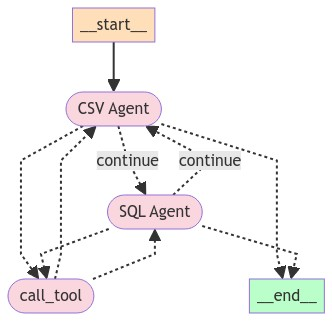

In [16]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=""" show me the tables with first five rows of sql.db a SQL database using SQL queries.
                """
                
            )
        ],
    },
    {"recursion_limit": 200},
)
for s in events:
    print(s)
    print("----")